# Estimacion del vCDR

Se busca la estimacion del vCDR, tanto en las predicciones obtenidas como en el groud trhts de las imagenes, a su vez se busca realizar un grafico de evaluacion 2

*cup to disc ratio (CDR)*


**vCDR = Vertical Cup-to-Disc Ratio** = d(OC)/d(OD)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import glob
import ntpath
import pandas as pd
import imageio as io
import numpy as np
from PIL import Image
from sklearn import metrics


In [22]:
predict_path = '/mnt/Almacenamiento/ODOC_segmentation/predicted/ModelM/'
data_path = '/mnt/Almacenamiento/ODOC_segmentation/data/'
dataset_predicted = 'ORIGA'
dataset_to_train = 'ORIGA'# 'DRIDHTI' 

In [23]:
def get_paths(data_pred,test=True):
    predicted_img_p = []
    predicted_OD_p = []
    predicted_OC_p = []
    gt_OD_p = []
    gt_OC_p = []

    for p in sorted(glob.glob(predict_path+ '/'+data_pred+'/OC/*')):
        predicted_OC_p.append(p)

    for p in sorted(glob.glob(predict_path+ '/'+data_pred+'/OD/*')):
        predicted_OD_p.append(p)

    if test:
        for p in sorted(glob.glob(data_path + 'images/' + data_pred + '/Test/*')):
            predicted_img_p.append(p)

        for p in sorted(glob.glob(data_path + 'OC/' + data_pred + '/Test/*')):
            gt_OC_p.append(p)

        for p in sorted(glob.glob(data_path + 'OD1/' + data_pred + '/Test/*')):
            gt_OD_p.append(p)
    else:
        for p in sorted(glob.glob(data_path + 'images/' + data_pred + '/*')):
            predicted_img_p.append(p)

        for p in sorted(glob.glob(data_path + 'OC/' + data_pred + '/*')):
            gt_OC_p.append(p)

        for p in sorted(glob.glob(data_path + 'OD1/' + data_pred + '/*')):
            gt_OD_p.append(p)

    return predicted_OC_p, predicted_OD_p, gt_OC_p, gt_OD_p

In [53]:
def get_vCDR_estimation(predicted_OC_p, predicted_OD_p, gt_OC_p, gt_OD_p):
    vCDR = []
    vCDR_gt = []

    for idx in range(len(predicted_OC_p)):
        pred_OC = np.array(Image.open(predicted_OC_p[idx]))
        gt_OC = np.array(Image.open(gt_OC_p[idx]))

        pred_OD = np.array(Image.open(predicted_OD_p[idx]))
        gt_OD = np.array(Image.open(gt_OD_p[idx]))
        
        dOC_pred = np.max(np.sum(pred_OC,axis=0))
        dOC_gt = np.max(np.sum(gt_OC,axis=0))

        dOD_pred = np.max(np.sum(pred_OD,axis=0))
        dOD_gt = np.max(np.sum(gt_OD,axis=0))

        vCDR.append(dOC_pred/dOD_pred)
        vCDR_gt.append(dOC_gt/dOD_gt)
      

    return vCDR, vCDR_gt

In [54]:
p_OC_D, p_OD_D, gt_OC_D, gt_OD_D = get_paths('DRISHTI',test=True)
vCDR_D, vCDR_gt_D = get_vCDR_estimation(p_OC_D, p_OD_D, gt_OC_D, gt_OD_D)

p_OC_D, p_OD_D, gt_OC_D, gt_OD_D = get_paths('RIM_ONE_R3',test=False)
vCDR_R3, vCDR_gt_R3 = get_vCDR_estimation(p_OC_D, p_OD_D, gt_OC_D, gt_OD_D)

p_OC_D, p_OD_D, gt_OC_D, gt_OD_D = get_paths('REFUGE',test=True)
vCDR_R, vCDR_gt_R = get_vCDR_estimation(p_OC_D, p_OD_D, gt_OC_D, gt_OD_D)

p_OC_D, p_OD_D, gt_OC_D, gt_OD_D = get_paths('ORIGA',test=False)
vCDR_O, vCDR_gt_O = get_vCDR_estimation(p_OC_D, p_OD_D, gt_OC_D, gt_OD_D)


vCDR_data_D= {
    'vCDR real' :vCDR_gt_D,
    'vCDR predicho':vCDR_D
    }

vCDR_data_R3={
    'vCDR real' :vCDR_gt_R3,
    'vCDR predicho':vCDR_R3
}

vCDR_data_R ={
    'vCDR real' :vCDR_gt_R,
    'vCDR predicho':vCDR_R
}

vCDR_data_O={
    'vCDR real' :vCDR_gt_O,
    'vCDR predicho':vCDR_O
}

df_D = pd.DataFrame(vCDR_data_D)
df_R3 = pd.DataFrame(vCDR_data_R3)
df_R = pd.DataFrame(vCDR_data_R)
df_O = pd.DataFrame(vCDR_data_O)


In [58]:
def cpearson(df):
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    correlation_matrix = np.corrcoef(df['vCDR predicho'], df['vCDR real'])
    #print('ĆORRELATION MATRIX', correlation_matrix)
    correlation_xy = correlation_matrix[0, 1]
    return correlation_xy



def r_squared(df):
    '''
    Compute the R2
    '''
    # remove any (inf, -inf, nan) values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    correlation_matrix = np.corrcoef(df['vCDR predicho'], df['vCDR real'])
    #print('ĆORRELATION MATRIX', correlation_matrix)
    correlation_xy = correlation_matrix[0, 1]
    r2 = correlation_xy ** 2
    
    return r2

def mae(df):
    '''
    Compute the Mean Absolute Error
    '''
    # remove any (inf, -inf, nan) values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    mea_value = metrics.mean_absolute_error(df['vCDR real'],df['vCDR predicho'])

    return mea_value

def RMSE(df):
    '''
    Compute the Root Mean Squared Error'''
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    mse_value = metrics.mean_squared_error(df['vCDR real'],df['vCDR predicho'])
    return np.sqrt(mse_value)

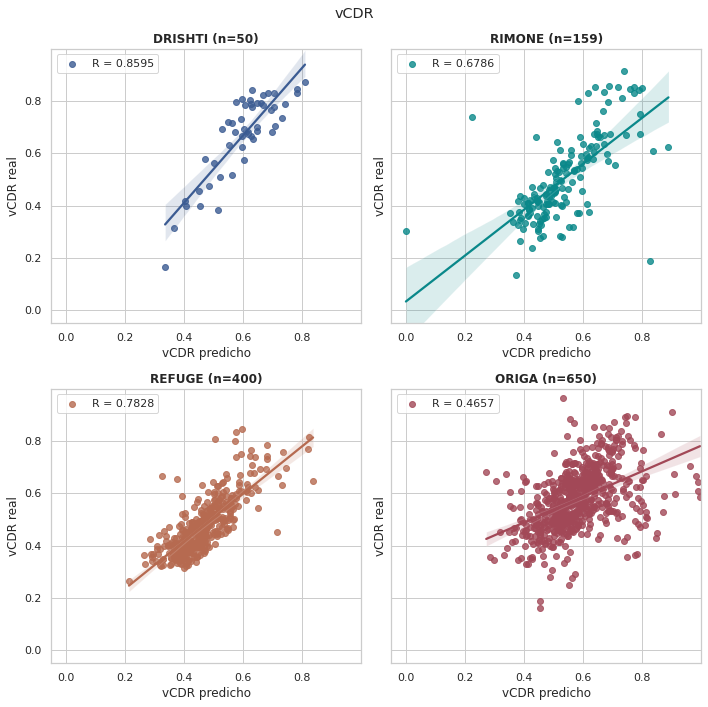

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
#fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=2,ncols=2, sharey=True)

sns.set_palette("Paired")

sns.set_theme(style="whitegrid")

# Set the ticks and ticklabels for all axes
plt.setp(axes, xticks=list(np.arange(0, 1, 0.2)),
        yticks=list(np.arange(0, 1, 0.2)), xlim=[-0.05,1], ylim=[-0.05,1])


plt.xlabel('vCDR predicho')
plt.ylabel('vCDR real')

sns.regplot(x='vCDR predicho',y='vCDR real',data=df_D,ax=axes[0,0],color=sns.xkcd_rgb["denim blue"])
axes[0,0].set_title('DRISHTI (n=50)',fontweight='bold')
axes[0,0].legend(['R = {:.4f}'.format(cpearson(df_D))], loc='upper left')

sns.regplot(x='vCDR predicho',y='vCDR real',data=df_R3,ax=axes[0,1],color=sns.xkcd_rgb["dark cyan"])
axes[0,1].set_title('RIMONE (n=159)',fontweight='bold')
axes[0,1].legend(['R = {:.4f}'.format(cpearson(df_R3))], loc='upper left')


sns.regplot(x='vCDR predicho',y='vCDR real',data=df_R,ax=axes[1,0],color=sns.xkcd_rgb["clay"])
axes[1,0].set_title('REFUGE (n=400)',fontweight='bold')
axes[1,0].legend(['R = {:.4f}'.format(cpearson(df_R))], loc='upper left')


sns.regplot(x='vCDR predicho',y='vCDR real',data=df_O,ax=axes[1,1],color=sns.xkcd_rgb["light maroon"])
axes[1,1].set_title('ORIGA (n=650)',fontweight='bold')
axes[1,1].legend(['R = {:.4f}'.format(cpearson(df_O))], loc='upper left')

fig.suptitle('vCDR')
plt.tight_layout()

plt.savefig('vCDR.jpg')



# Generar tabla de metricas
generamos una tabla de metricas conel Mean Absolute Error, el RMSE radio de(mean squared error), R

In [65]:
import pandas as pd

datasets = ['DRISHTI', 'REFUGE', 'RIM_ONE_V3','ORIGA']

final_df = pd.DataFrame()
final_df['Dataset']=datasets

dMAE = mae(df_D)
rMAE = mae(df_R)
r3MAE = mae(df_R3)
oMAE = mae(df_O)

final_df['MAE']= [dMAE,rMAE,r3MAE,oMAE]

dMAE = RMSE(df_D)
rMAE = RMSE(df_R)
r3MAE = RMSE(df_R3)
oMAE = RMSE(df_O)

final_df['RMSE']= [dMAE,rMAE,r3MAE,oMAE]

dMAE = cpearson(df_D)
rMAE = cpearson(df_R)
r3MAE = cpearson(df_R3)
oMAE = cpearson(df_O)

final_df['R']= [dMAE,rMAE,r3MAE,oMAE]

dMAE = r_squared(df_D)
rMAE = r_squared(df_R)
r3MAE = r_squared(df_R3)
oMAE = r_squared(df_O)

final_df['R2']= [dMAE,rMAE,r3MAE,oMAE]


final_df

,Dataset,MAE,RMSE,R,R2
0,DRISHTI,0.089863,0.109670,0.859465,0.738681
1,REFUGE,0.048541,0.066996,0.782786,0.612755
2,RIM_ONE_V3,0.083774,0.121977,0.678622,0.460528
3,ORIGA,0.085379,0.117393,0.465663,0.216842
